In [1]:
!pip install d2l==1.0.0-alpha1.post0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.3 MB/s 
     |████████████████████████████████| 120 kB 34.0 MB/s 
     |████████████████████████████████| 1.6 MB 65.3 MB/s 
     |████████████████████████████████| 82 kB 453 kB/s 


## Implementation from Scratch
Now let's implement an LSTM from scratch. As same as the experiments in :numref:sec_rnn-scratch, we first load The Time Machine dataset.

In [2]:
import tensorflow as tf
from d2l import tensorflow as d2l

### [**Initializing Model Parameters**]

Next, we need to define and initialize the model parameters. 
As previously, the hyperparameter `num_hiddens` 
dictates the number of hidden units.
We initialize weights following a Gaussian distribution
with 0.01 standard deviation, 
and we set the biases to 0.


In [3]:
class LSTMScratch(d2l.Module):  #@save
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: tf.Variable(tf.random.normal(shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          tf.Variable(tf.zeros(num_hiddens)))

        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

[**The actual model**] is defined as described above,
consisting of three gates and an input node. 
Note that only the hidden state is passed to the output layer.


In [4]:
@d2l.add_to_class(LSTMScratch)
def forward(self, inputs, H_C=None):
    H, C = None, None if H_C is None else H_C
    outputs = []
    for X in inputs:
        I = tf.sigmoid(tf.matmul(X, self.W_xi) + (
            tf.matmul(H, self.W_hi) if H is not None else 0) + self.b_i)
        if H is None:
            H, C = tf.zeros_like(I), tf.zeros_like(I)
        F = tf.sigmoid(tf.matmul(X, self.W_xf) +
                        tf.matmul(H, self.W_hf) + self.b_f)
        O = tf.sigmoid(tf.matmul(X, self.W_xo) +
                        tf.matmul(H, self.W_ho) + self.b_o)
        C_tilde = tf.tanh(tf.matmul(X, self.W_xc) +
                           tf.matmul(H, self.W_hc) + self.b_c)
        C = F * C + I * C_tilde
        H = O * tf.tanh(C)
        outputs.append(H)
    return outputs, (H, C)

### [**Training**] and Prediction

Let's train an LSTM model by instantiating the `RNNLMScratch` class as introduced in :numref:`sec_rnn-scratch`.


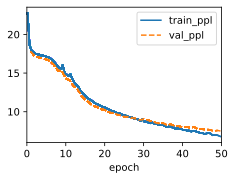

In [5]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
with d2l.try_gpu():
    lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
    model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1)
trainer.fit(model, data)

## [**Concise Implementation**]

Using high-level APIs,
we can directly instantiate an LSTM model.
This encapsulates all the configuration details 
that we made explicit above. 
The code is significantly faster as it uses 
compiled operators rather than Python
for many details that we spelled out before.


In [6]:
class LSTM(d2l.RNN):
    def __init__(self, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = tf.keras.layers.LSTM(
                num_hiddens, return_sequences=True,
                return_state=True, time_major=True)

    def forward(self, inputs, H_C=None):
        outputs, *H_C = self.rnn(inputs, H_C)
        return outputs, H_C

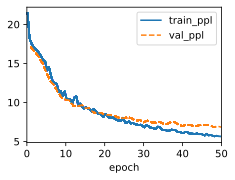

In [7]:
lstm = LSTM(num_hiddens=32)
with d2l.try_gpu():
    model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [8]:
model.predict('it has', 20, data.vocab)

'it has a ment an a man all'